In [33]:
from z3 import *
from itertools import product
from functools import reduce
import operator
import seaborn as sns
import matplotlib.pyplot as plt


from pathlib import Path
from IPython.display import Image, display

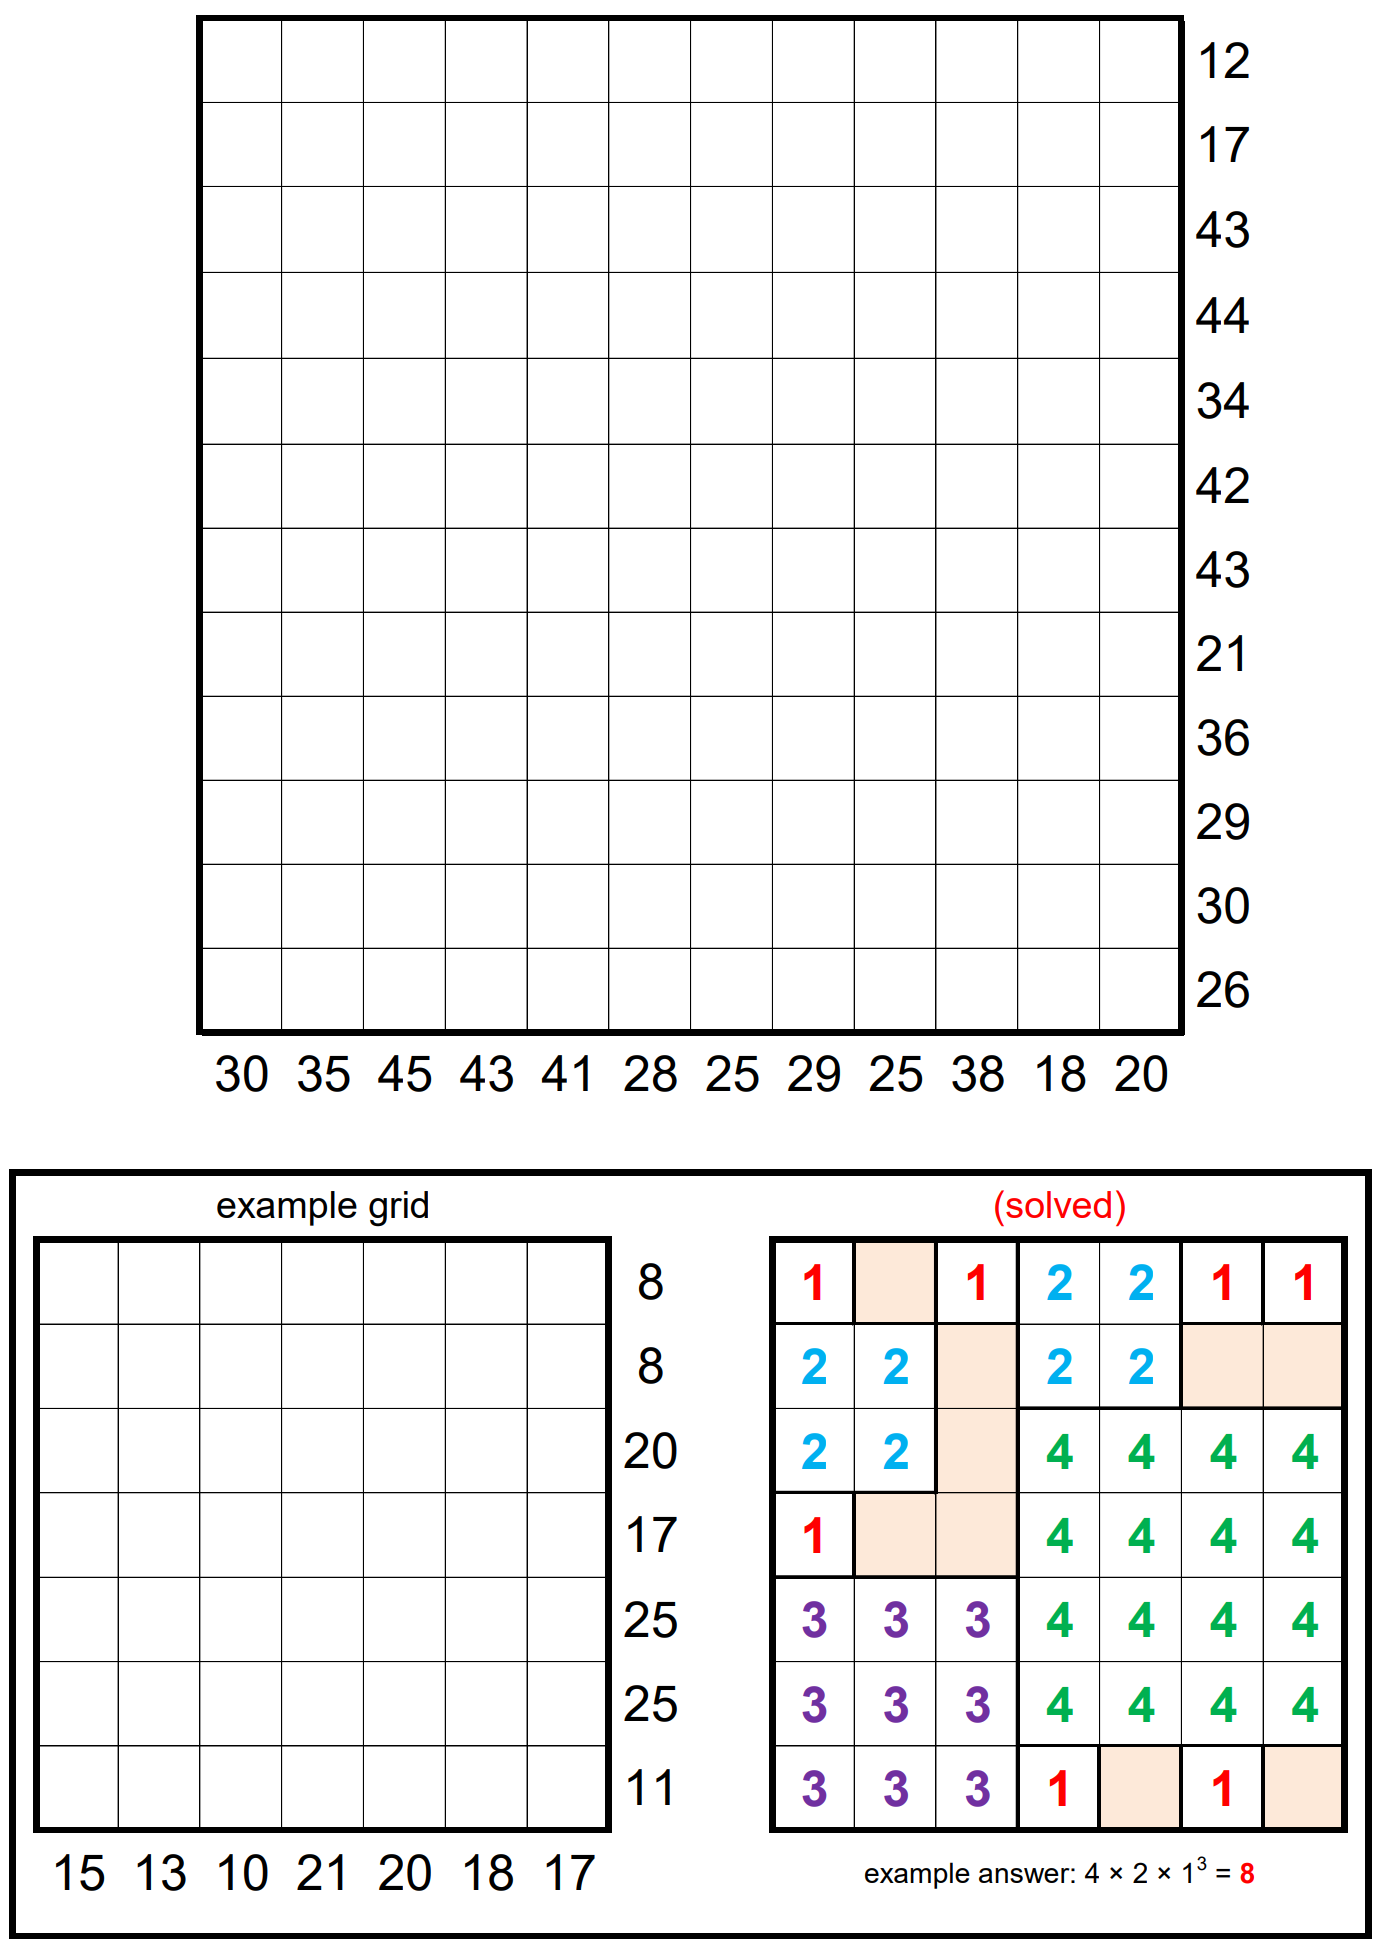

In [11]:
root = Path.cwd()
png_path = root / "Example.png"
display(Image(filename = png_path))

In [12]:
size = 12
max_size = 5

grid = [[Int(f'cell_{r}_{c}') for r in range(size)] for c in range(size)]

Since the maximum sum demanded of any arbitrary row/column is $45$, clearly we may not input tiles any bigger than size $6\times 6$ as a $7\times 7$ tile would necessitate result in values $\geq 49$. Taking this logic further, if we were to see a $6\times 6$ tile, then clearly there should be a sequence of column/row sums of length $\geq 6$ that are all larger than $36$. Since this is not the case (but is the case for length $5$, number $25$), we see that the maximum size any tile can be is $5\times 5$.

In [13]:
constraints = []

for c, r in product(range(size), range(size)):
    constraints.append(And(grid[r][c] >= 0, grid[r][c] <= max_size))

row_sums = [12, 17, 43, 44, 34, 42, 43, 21, 36, 29, 30, 26]
col_sums = [30, 35, 45, 43, 41, 28, 25, 29, 25, 38, 18, 20]

for r in range(size):
    row_num = Sum([grid[r][c] for c in range(size)])
    constraints.append(row_num == row_sums[r])

for c in range(size):
    col_num = Sum([grid[r][c] for r in range(size)])
    constraints.append(col_num == col_sums[c])

for r, c in product(range(size), range(size)):
    for s in range(1, max_size + 1):
        if r + s <= size and c + s <= size:
            cells = [grid[r + dr][c + dc] for dr in range(s) for dc in range(s)]
            constraints.append(Implies(grid[r][c] == s, And([cell == s for cell in cells])))

In [21]:
row_sums = [12, 17, 43, 44, 34, 42, 43, 21, 36, 29, 30, 26]
col_sums = [30, 35, 45, 43, 41, 28, 25, 29, 25, 38, 18, 20]

n = 12
max_num = 5

constraints = []

tile_check = {} #tile_check[(i,j,s)] == True if a s x s tile has may be placed on (i,j)
for i, j in product(range(n), range(n)):
    for s in range(1, max_num + 1):
        if i + s <= n and j + s <= n:
            tile_check[(i, j, s)] = Bool(f"Origin_{i}_{j}_Size_{s}")

for r, c in product(range(n), range(n)):
    covering_tiles = []
    for i, j, s in tile_check:
        if i <= r < i + s and j <= c < j + s:
            covering_tiles.append(tile_check[(i, j, s)])
    if covering_tiles:
        constraints.append(Sum([If(t, 1, 0) for t in covering_tiles]) <= 1)

for r in range(n):
    row_tiles = []
    for i, j, s in tile_check:
        if i <= r < i + s:
            row_tiles.append(If(tile_check[(i, j, s)], s ** 2, 0))
    constraints.append(Sum(row_tiles) == row_sums[r])

for c in range(n):
    col_tiles = []
    for i, j, s in tile_check:
        if j <= c < j + s:
            col_tiles.append(If(tile_check[(i, j, s)], s * s, 0))
    constraints.append(Sum(col_tiles) == col_sums[c])

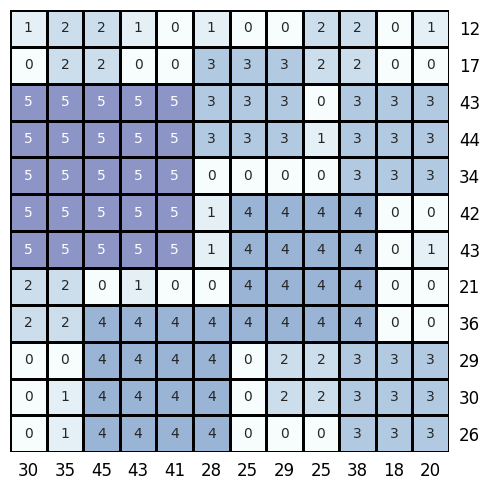

Product of empty areas: 20160


In [47]:
solver = Solver()
solver.add(constraints)

if solver.check() == sat:
    model = solver.model()
    
    grid = [[0 for _ in range(n)] for _ in range(n)]
    for (i, j, s), var in tile_check.items():
        if model.evaluate(var):
            for di, dj in product(range(s), range(s)):
                grid[i + di][j + dj] = s

    fig, ax = plt.subplots(1, 1, figsize = (5, 5))    
    ax = sns.heatmap(
        grid,
        annot = grid,
        cbar = False,
        cmap = 'BuPu',
        linewidths = 1,
        linecolor = "black",
        xticklabels = col_sums, 
        yticklabels = row_sums
    )
    ax.tick_params(
        left = False, 
        bottom = False,
        labelleft = False, 
        labelright = True
    )
    plt.xticks(rotation = 0, fontsize = 12)
    plt.yticks(rotation = 0, fontsize = 12)
    plt.tight_layout()
    plt.show()   

    
    visited = [[False] * n for _ in range(n)]
    
    def dfs(r, c):
        stack = [(r, c)]
        area = 0
        while stack:
            x, y = stack.pop()
            if 0 <= x < n and 0 <= y < n and not visited[x][y] and grid[x][y] == 0:
                visited[x][y] = True
                area += 1
                stack.extend([(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)])
        return area

    empty_areas = []
    for r in range(n):
        for c in range(n):
            if grid[r][c] == 0 and not visited[r][c]:
                empty_areas.append(dfs(r, c))
    
    product_empty = reduce(operator.mul, empty_areas, 1)
    print("Product of empty areas:", product_empty)

else:
    print("No solution found")